In [20]:
import sounddevice as sd
import soundfile as sf
from python_speech_features import mfcc
from sklearn.preprocessing import normalize, StandardScaler
from joblib import load
import os
import numpy as np
from scipy.signal import lfilter, butter

def record_audio(file_path, duration=1, sr=16000, noise_reduction=True, filter_length=100, volume_scale=20):
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()

    # Apply noise reduction
    if noise_reduction:
            cutoff_freq = 300.0  # Hz
            b, a = butter(5, cutoff_freq / (sr / 2), btype='high')
            audio = lfilter(b, a, audio)

            # Apply moving average filter for further noise reduction
            audio = lfilter(np.ones(filter_length) / filter_length, 1, audio)

    audio *= volume_scale
    
    # Normalize audio to prevent clipping
    max_amplitude = np.max(np.abs(audio))
    if max_amplitude > 0.6:
        audio /= max_amplitude
    
    # Save audio to WAV file
    sf.write(file_path, audio, samplerate=sr, subtype='PCM_16')

    return file_path


def predict_label(file_path):
    audio, sr = sf.read(file_path)

    # Normalize audio
    normalized_audio = normalize(audio.reshape(1, -1)).reshape(-1)

    # Extract MFCC features
    mfcc_features = mfcc(normalized_audio, sr, nfft=2048)

    # Normalize the features
    scaler = StandardScaler()
    mfcc_features_scaled = scaler.fit_transform(mfcc_features)

    # Reshape the data for compatibility with classifiers
    mfcc_features_flat = mfcc_features_scaled.reshape(1, -1)

    # Limit the features to 1287
    mfcc_features_1287 = mfcc_features_flat[:, :1287]

    model = load("SVM_model.joblib")
    # Make a prediction using the loaded model
    predicted_label = model.predict(mfcc_features_1287.reshape(1, -1))

    label_encoder = load("label_encoder.joblib")
    # Decode the predicted label
    decoded_label = label_encoder.inverse_transform(predicted_label)
    return decoded_label[0]

# Path to the audio file you want to predict
file_path = "Recordings"
# Record audio
print("Listening")
audio_file_path = record_audio(os.path.join(file_path, "test.wav"))

print(predict_label(audio_file_path))


left


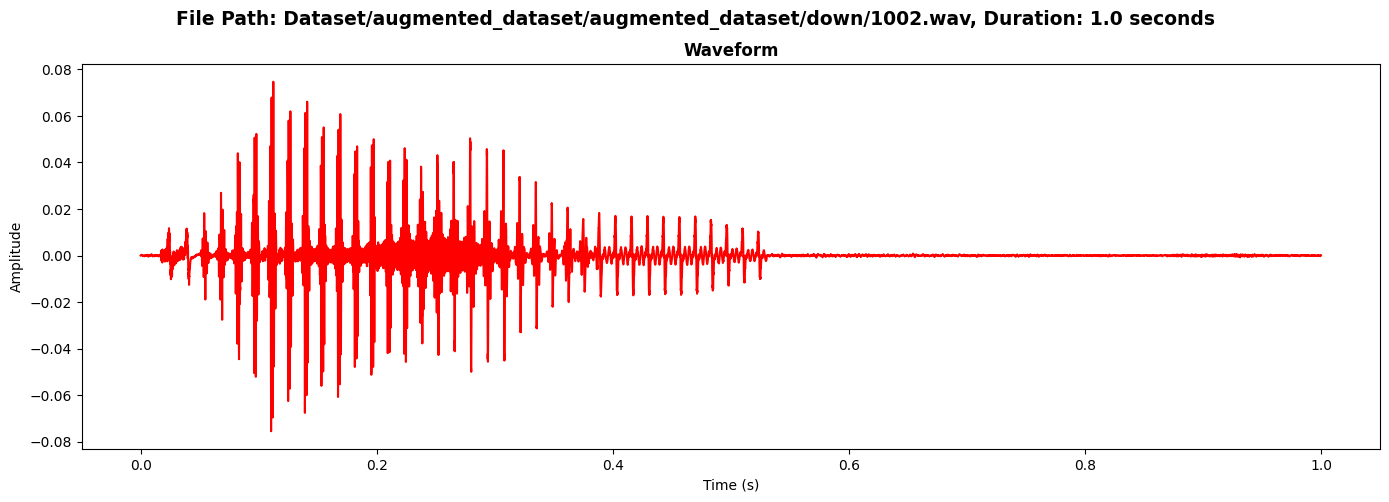

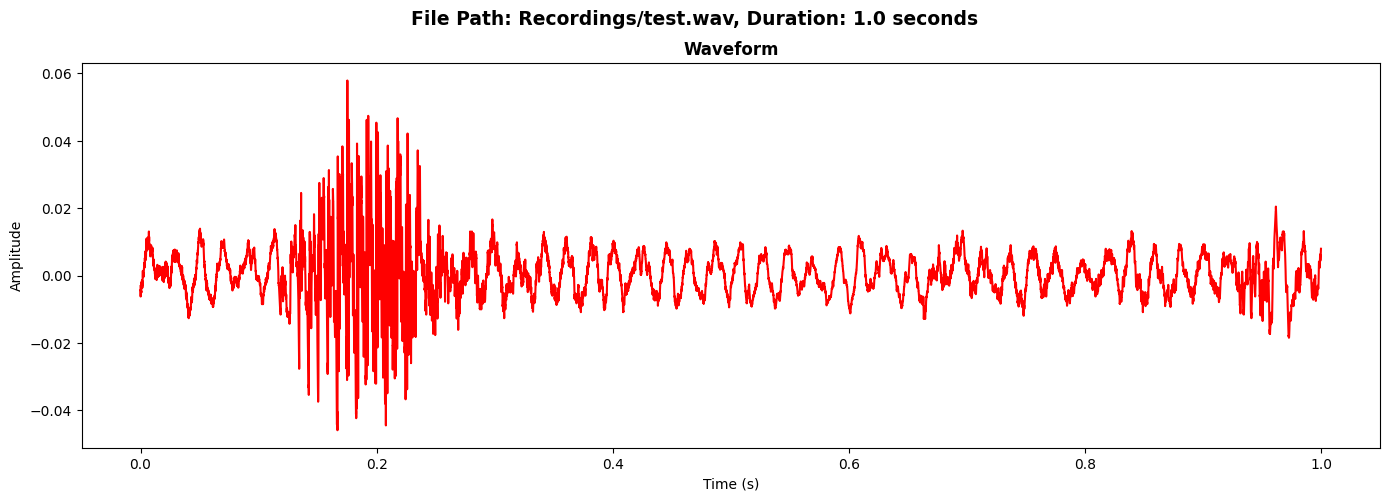

In [21]:
import soundfile as sf
import numpy as np
from python_speech_features import mfcc
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.signal import get_window

def calculate_spectrogram(audio,N=512, hop_length=256):
    window = get_window('hann', N)
    spec = np.abs(np.array([np.fft.fft(window * audio[i:i+N]) for i in range(0, len(audio)-N, hop_length)]))
    spec = 20 * np.log10(spec)
    return spec

def plot_audio(file_path):
    try:
        # Load audio file
        audio, sr = sf.read(file_path)
        
        # Normalize audio
        normalized_audio = normalize(audio.reshape(1, -1)).reshape(-1)
        
        # Calculate dBFS levels
        interval_size = int(sr / 100)
        dbfs_levels = [20 * np.log10(np.max(np.abs(normalized_audio[i:i+interval_size]))) 
                    for i in range(0, len(normalized_audio), interval_size)]
        
        # Extract MFCC features
        mfcc_features = mfcc(normalized_audio, sr)

        duration = len(normalized_audio) / sr
        
        # Visualize audio
        plt.figure(figsize=(14, 18))
        plt.suptitle(f'File Path: {file_path}, Duration: {duration} seconds', fontsize=13.5, fontweight='bold', y=0.99, ha='center')
        
        # Plot waveform
        plt.subplot(4, 1, 1)
        plt.plot(np.linspace(0, len(normalized_audio) / sr, len(normalized_audio)), normalized_audio, color='r')
        plt.title('Waveform', fontsize=12, fontweight='semibold')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # # Calculate and plot spectrogram
        # plt.subplot(4, 1, 2)
        # spec = calculate_spectrogram(normalized_audio)
        # plt.imshow(spec.T, aspect='auto', origin='lower', extent=[0, len(normalized_audio) / sr, 0, sr / 2])
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Spectrogram', fontsize=12, fontweight='semibold')
        # plt.xlabel('Time (s)')
        # plt.ylabel('Frequency (Hz)')
        
        
        # # Plot MFCC features
        # plt.subplot(4, 1, 3)
        # plt.imshow(mfcc_features.T, aspect='auto', origin='lower', cmap='viridis')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('MFCC', fontsize=12, fontweight='semibold')
        # plt.xlabel('Time')
        # plt.ylabel('MFCC Coefficient')
        

        # # Plot dBFS levels
        # plt.subplot(4, 1, 4)
        # duration = len(normalized_audio) / sr
        # plt.plot(np.linspace(0, duration, len(dbfs_levels)), dbfs_levels, color='red')
        # plt.xlabel('Time (s)')
        # plt.ylabel('dBFS')
        # plt.title('dBFS Levels (per 100 ms)', fontsize=12, fontweight='semibold')
        # plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


# Plot the randomly selected file
plot_audio("Dataset/augmented_dataset/augmented_dataset/down/1002.wav")
plot_audio("Recordings/test.wav")